In [1]:
%matplotlib inline

import sys, os
sys.path.insert(0, '../../../../vision/')
sys.path.append('../../../../../pytorch-segmentation-detection/')

# Use second GPU -pytorch-segmentation-detection- change if you want to use a first one
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

from PIL import Image
from matplotlib import pyplot as plt

import torch
from torchvision import transforms
import torchvision
from torch.autograd import Variable
import pytorch_segmentation_detection.models.resnet_dilated as resnet_dilated
from pytorch_segmentation_detection.layers import GlobalAvgPool2d

import numpy as np
import torch.nn as nn

from pytorch_segmentation_detection.datasets.pascal_voc import PascalVOCSegmentation

#from adaptive_computation_time import ACT_Module

import pytorch_segmentation_detection.models.fcn as fcns
import pytorch_segmentation_detection.models.resnet_dilated as resnet_dilated
from pytorch_segmentation_detection.transforms import (ComposeJoint,
                                                       RandomHorizontalFlipJoint,
                                                       RandomScaleJoint,
                                                       CropOrPad,
                                                       ResizeAspectRatioPreserve,
                                                       RandomCropJoint,
                                                       Split2D)

from matplotlib import pyplot as plt

import numpy as np
import torch.optim as optim
from PIL import Image

from sklearn.metrics import confusion_matrix

def flatten_logits(logits, number_of_classes):
    """Flattens the logits batch except for the logits dimension"""
    
    logits_permuted = logits.permute(0, 2, 3, 1)
    logits_permuted_cont = logits_permuted.contiguous()
    logits_flatten = logits_permuted_cont.view(-1, number_of_classes)
    
    return logits_flatten

def flatten_annotations(annotations):
    
    return annotations.view(-1)

def get_valid_annotations_index(flatten_annotations, mask_out_value=255):
    
    return torch.squeeze( torch.nonzero((flatten_annotations != mask_out_value )), 1)

def adjust_learning_rate(optimizer, iteration):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    
    max_iteration = 10000.0
    
    multiplier = (1.0 - (iteration / max_iteration)) ** (0.9)
    
    lr = 0.0001 * multiplier
    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr


from pytorch_segmentation_detection.transforms import RandomCropJoint


number_of_classes = 21

labels = range(number_of_classes)

In [2]:
train_transform = ComposeJoint(
                [
                    RandomHorizontalFlipJoint(),
                    RandomCropJoint(crop_size=(513, 513)),
                    [transforms.ToTensor(), None],
                    [transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), None],
                    [None, transforms.Lambda(lambda x: torch.from_numpy(np.asarray(x)).long()) ]
                ])

path_to_VOC = '/media/peteflo/3TBbackup/pytorch-pretrained/VOC'

trainset = PascalVOCSegmentation(path_to_VOC,
                                 download=False,
                                 joint_transform=train_transform)


trainloader = torch.utils.data.DataLoader(trainset, batch_size=10,
                                          shuffle=True, num_workers=4, drop_last=True)



valid_transform = ComposeJoint(
                [
                     [transforms.ToTensor(), None],
                     [transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), None],
                     [None, transforms.Lambda(lambda x: torch.from_numpy(np.asarray(x)).long()) ]
                ])


valset = PascalVOCSegmentation(path_to_VOC,
                               train=False,
                               download=False,
                               joint_transform=valid_transform)


valset_loader = torch.utils.data.DataLoader(valset, batch_size=1,
                                            shuffle=False, num_workers=2)

train_subset_sampler = torch.utils.data.sampler.SubsetRandomSampler(xrange(904))
train_subset_loader = torch.utils.data.DataLoader(dataset=trainset, batch_size=1,
                                                   sampler=train_subset_sampler,
                                                   num_workers=2)

# Define the validation function to track MIoU during the training
def validate():
    
    fcn.eval()
    
    overall_confusion_matrix = None

    for image, annotation in valset_loader:

        image = Variable(image.cuda())
        logits = fcn(image)

        # First we do argmax on gpu and then transfer it to cpu
        logits = logits.data
        _, prediction = logits.max(1)
        prediction = prediction.squeeze(1)

        prediction_np = prediction.cpu().numpy().flatten()
        annotation_np = annotation.numpy().flatten()

        # Mask-out value is ignored by default in the sklearn
        # read sources to see how that was handled

        current_confusion_matrix = confusion_matrix(y_true=annotation_np,
                                                    y_pred=prediction_np,
                                                    labels=labels)

        if overall_confusion_matrix is None:


            overall_confusion_matrix = current_confusion_matrix
        else:

            overall_confusion_matrix += current_confusion_matrix
    
    
    intersection = np.diag(overall_confusion_matrix)
    ground_truth_set = overall_confusion_matrix.sum(axis=1)
    predicted_set = overall_confusion_matrix.sum(axis=0)
    union =  ground_truth_set + predicted_set - intersection

    intersection_over_union = intersection / union.astype(np.float32)
    mean_intersection_over_union = np.mean(intersection_over_union)
    
    fcn.train()

    return mean_intersection_over_union


def validate_train():
    
    fcn.eval()
    
    overall_confusion_matrix = None

    for image, annotation in train_subset_loader:

        image = Variable(image.cuda())
        logits = fcn(image)

        # First we do argmax on gpu and then transfer it to cpu
        logits = logits.data
        _, prediction = logits.max(1)
        prediction = prediction.squeeze(1)

        prediction_np = prediction.cpu().numpy().flatten()
        annotation_np = annotation.numpy().flatten()

        # Mask-out value is ignored by default in the sklearn
        # read sources to see how that was handled

        current_confusion_matrix = confusion_matrix(y_true=annotation_np,
                                                    y_pred=prediction_np,
                                                    labels=labels)

        if overall_confusion_matrix is None:


            overall_confusion_matrix = current_confusion_matrix
        else:

            overall_confusion_matrix += current_confusion_matrix
    
    
    intersection = np.diag(overall_confusion_matrix)
    ground_truth_set = overall_confusion_matrix.sum(axis=1)
    predicted_set = overall_confusion_matrix.sum(axis=0)
    union =  ground_truth_set + predicted_set - intersection

    intersection_over_union = intersection / union.astype(np.float32)
    mean_intersection_over_union = np.mean(intersection_over_union)
    
    fcn.train()

    return mean_intersection_over_union

<IPython.core.display.Javascript object>


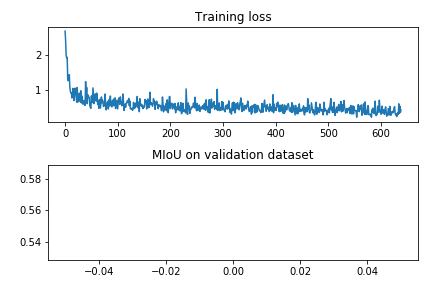

In [3]:
%matplotlib notebook

from matplotlib import pyplot as plt


# Create the training plot
loss_current_iteration = 0
loss_history = []
loss_iteration_number_history = []

validation_current_iteration = 0
validation_history = []
validation_iteration_number_history = []

train_validation_current_iteration = 0
train_validation_history = []
train_validation_iteration_number_history = []
 
f, (loss_axis, validation_axis) = plt.subplots(2, 1)

loss_axis.plot(loss_iteration_number_history, loss_history)
validation_axis.plot(validation_iteration_number_history, validation_history, 'b',
                     train_validation_iteration_number_history, train_validation_history, 'r')

loss_axis.set_title('Training loss')
validation_axis.set_title('MIoU on validation dataset')

plt.tight_layout()

In [4]:
fcn = resnet_dilated.Resnet34_8s(num_classes=21)
fcn.cuda()
fcn.train()

# for idx, m in enumerate(fcn.modules()):
#      print(idx, '->', m)

criterion = nn.CrossEntropyLoss(size_average=False).cuda()

optimizer = optim.Adam(fcn.parameters(), lr=0.0001, weight_decay=0.0001)

/usr/local/lib/python2.7/dist-packages/torch/nn/modules/module.py:482: UserWarning: src is not broadcastable to dst, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  own_state[name].copy_(param)


In [ ]:
# This debug cell can iterate over all of the images and show what is happening in the transform
# Note that it's really the composed transforms which do all of the hard work, taking a PIL
# image and turning it into a batch of tensors

# %matplotlib inline

# debug_transform = ComposeJoint(
#                 [
#                     RandomCropJoint(crop_size=(513, 513)),
#                     [transforms.ToTensor(), None],
#                     [None, transforms.Lambda(lambda x: torch.from_numpy(np.asarray(x)).long()) ]
#                 ])

# path_to_VOC = '/media/peteflo/3TBbackup/pytorch-pretrained/VOC'

# trainset = PascalVOCSegmentation(path_to_VOC,
#                                  download=False,
#                                  joint_transform=debug)


# trainloader = torch.utils.data.DataLoader(trainset, batch_size=10,
#                                           shuffle=True, num_workers=1, drop_last=True)

# for i, data in enumerate(trainloader,0):
#     img, anno = data
#     print "img shape before indexing", img.shape
#     img = img[0,:,:,:]
#     print "img shape after indexing", img.shape
#     img = img.permute(1, 2, 0)
#     print "img shape after permute", img.shape
#     #print img    
#     plt.imshow(img)
#     plt.show()
#     #print "anno shape", anno.shape
#     plt.imshow(anno[0,:,:])
#     plt.show()

In [ ]:
import time

best_validation_score = 0

iter_size = 20

for epoch in range(130):  # loop over the dataset multiple times

    running_loss = 0.0
    
    for i, data in enumerate(trainloader, 0):
        start = time.time()
        
        # get the inputs
        img, anno = data
        
        # We need to flatten annotations and logits to apply index of valid
        # annotations. All of this is because pytorch doesn't have tf.gather_nd()
        anno_flatten = flatten_annotations(anno)
        index = get_valid_annotations_index(anno_flatten, mask_out_value=255)
        anno_flatten_valid = torch.index_select(anno_flatten, 0, index)

        # wrap them in Variable
        # the index can be acquired on the gpu
        img, anno_flatten_valid, index = Variable(img.cuda()), Variable(anno_flatten_valid.cuda()), Variable(index.cuda())
        #print "img shape, ", img.shape

        # zero the parameter gradients
        optimizer.zero_grad()
        
        adjust_learning_rate(optimizer, loss_current_iteration)

        # forward + backward + optimize
        logits = fcn(img)
        #print "logits shape", logits.shape
        #print "logits is", logits
        logits_flatten = flatten_logits(logits, number_of_classes=21)
        #print "logits flatten shape", logits_flatten.shape
        logits_flatten_valid = torch.index_select(logits_flatten, 0, index)
        #print "logits_flatten_valid shape", logits_flatten_valid.shape
        
        loss = criterion(logits_flatten_valid, anno_flatten_valid)# + ponder_cost.sum() * 0.1
        loss.backward()
        optimizer.step()
        
        print time.time() - start, " seconds on gpu " + os.environ["CUDA_VISIBLE_DEVICES"]

        # print statistics
        running_loss += (loss.data[0] / logits_flatten_valid.size(0)) 
        if i % 2 == 1:
            
            
            loss_history.append(running_loss / 2)
            loss_iteration_number_history.append(loss_current_iteration)
            
            loss_current_iteration += 1
            
            loss_axis.lines[0].set_xdata(loss_iteration_number_history)
            loss_axis.lines[0].set_ydata(loss_history)

            loss_axis.relim()
            loss_axis.autoscale_view()
            loss_axis.figure.canvas.draw()
            
            running_loss = 0.0
            
        
            
    current_validation_score = validate()
    validation_history.append(current_validation_score)
    validation_iteration_number_history.append(validation_current_iteration)

    validation_current_iteration += 1

    validation_axis.lines[0].set_xdata(validation_iteration_number_history)
    validation_axis.lines[0].set_ydata(validation_history)



    current_train_validation_score = validate_train()
    train_validation_history.append(current_train_validation_score)
    train_validation_iteration_number_history.append(train_validation_current_iteration)

    train_validation_current_iteration += 1

    validation_axis.lines[1].set_xdata(train_validation_iteration_number_history)
    validation_axis.lines[1].set_ydata(train_validation_history)


    validation_axis.relim()
    validation_axis.autoscale_view()
    validation_axis.figure.canvas.draw()

    # Save the model if it has a better MIoU score.
    if current_validation_score > best_validation_score:

        torch.save(fcn.state_dict(), 'resnet_34_8s.pth')
        best_validation_score = current_validation_score
        print(best_validation_score)
    
        
                

print('Finished Training')

/usr/local/lib/python2.7/dist-packages/torch/nn/functional.py:1423: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.upsample instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.upsample instead.")


2.15004301071  seconds on gpu 1
1.41592288017  seconds on gpu 1
1.43736982346  seconds on gpu 1
1.42802500725  seconds on gpu 1
1.47124910355  seconds on gpu 1
1.42303800583  seconds on gpu 1
1.43023896217  seconds on gpu 1
1.44316697121  seconds on gpu 1
1.42517590523  seconds on gpu 1
1.43202710152  seconds on gpu 1
1.43505001068  seconds on gpu 1
1.42814087868  seconds on gpu 1
1.44660806656  seconds on gpu 1
1.45053005219  seconds on gpu 1
1.4463789463  seconds on gpu 1
1.44911003113  seconds on gpu 1
1.44525504112  seconds on gpu 1
1.44879603386  seconds on gpu 1
1.44185686111  seconds on gpu 1
1.44805908203  seconds on gpu 1
1.44997000694  seconds on gpu 1
1.43372392654  seconds on gpu 1
1.44300293922  seconds on gpu 1
1.43550896645  seconds on gpu 1
1.44589400291  seconds on gpu 1
1.44225811958  seconds on gpu 1
1.43386793137  seconds on gpu 1
1.42006897926  seconds on gpu 1
1.44212079048  seconds on gpu 1
1.4350540638  seconds on gpu 1
1.45589113235  seconds on gpu 1
1.45204782

1.51551008224  seconds on gpu 1
1.49622583389  seconds on gpu 1
1.47041010857  seconds on gpu 1
1.4807779789  seconds on gpu 1
1.50334191322  seconds on gpu 1
1.50607800484  seconds on gpu 1
1.47596597672  seconds on gpu 1
1.50926303864  seconds on gpu 1
1.4934091568  seconds on gpu 1
1.50170397758  seconds on gpu 1
1.4892449379  seconds on gpu 1
1.51357603073  seconds on gpu 1
1.481372118  seconds on gpu 1
1.48519587517  seconds on gpu 1
1.49109506607  seconds on gpu 1
1.48659801483  seconds on gpu 1
1.47960400581  seconds on gpu 1
1.51404905319  seconds on gpu 1
1.5032119751  seconds on gpu 1
1.48461794853  seconds on gpu 1
1.49466013908  seconds on gpu 1
1.48665213585  seconds on gpu 1
1.53083109856  seconds on gpu 1
1.50283384323  seconds on gpu 1
1.48917484283  seconds on gpu 1
1.47450613976  seconds on gpu 1
1.52588200569  seconds on gpu 1
1.47179603577  seconds on gpu 1
1.49472594261  seconds on gpu 1
1.49302196503  seconds on gpu 1
1.48643898964  seconds on gpu 1
1.49855709076 

1.49805784225  seconds on gpu 1
1.4803841114  seconds on gpu 1
1.48452711105  seconds on gpu 1
1.51607298851  seconds on gpu 1
1.51244497299  seconds on gpu 1
1.52645802498  seconds on gpu 1
1.48389410973  seconds on gpu 1
1.48091411591  seconds on gpu 1
1.4862511158  seconds on gpu 1
1.49304485321  seconds on gpu 1
1.48316001892  seconds on gpu 1
1.49474978447  seconds on gpu 1
1.50973105431  seconds on gpu 1
1.49217987061  seconds on gpu 1
1.50544500351  seconds on gpu 1
1.48659110069  seconds on gpu 1
1.50293493271  seconds on gpu 1
1.49401593208  seconds on gpu 1
1.51380991936  seconds on gpu 1
1.49844908714  seconds on gpu 1
1.5172560215  seconds on gpu 1
1.50470304489  seconds on gpu 1
1.49409198761  seconds on gpu 1
1.49587798119  seconds on gpu 1
1.5150179863  seconds on gpu 1
1.52570295334  seconds on gpu 1
1.49881982803  seconds on gpu 1
1.49431705475  seconds on gpu 1
1.47802305222  seconds on gpu 1
1.49753808975  seconds on gpu 1
1.47576713562  seconds on gpu 1
1.5103938579

1.51235198975  seconds on gpu 1
1.51052808762  seconds on gpu 1
1.51924085617  seconds on gpu 1
1.5256690979  seconds on gpu 1
1.51272010803  seconds on gpu 1
1.50044894218  seconds on gpu 1
1.49278998375  seconds on gpu 1
1.49916505814  seconds on gpu 1
1.50477218628  seconds on gpu 1
1.51970791817  seconds on gpu 1
1.50892281532  seconds on gpu 1
1.50450491905  seconds on gpu 1
1.4771771431  seconds on gpu 1
1.50036811829  seconds on gpu 1
1.50667595863  seconds on gpu 1
1.50578403473  seconds on gpu 1
1.49956798553  seconds on gpu 1
1.50685095787  seconds on gpu 1
1.50084996223  seconds on gpu 1
1.48897790909  seconds on gpu 1
1.48690795898  seconds on gpu 1
1.49512195587  seconds on gpu 1
1.49604296684  seconds on gpu 1
1.50788903236  seconds on gpu 1
1.52631092072  seconds on gpu 1
1.51541614532  seconds on gpu 1
1.4900829792  seconds on gpu 1
1.50294494629  seconds on gpu 1
1.51594805717  seconds on gpu 1
1.51287007332  seconds on gpu 1
1.51062679291  seconds on gpu 1
1.474534034

1.4934899807  seconds on gpu 1
1.49760198593  seconds on gpu 1
1.50270819664  seconds on gpu 1
1.50726294518  seconds on gpu 1
1.4990811348  seconds on gpu 1
1.48530006409  seconds on gpu 1
1.50627803802  seconds on gpu 1
1.49524903297  seconds on gpu 1
1.49216103554  seconds on gpu 1
1.49315881729  seconds on gpu 1
1.52228188515  seconds on gpu 1
1.50311803818  seconds on gpu 1
1.4857981205  seconds on gpu 1
1.50711917877  seconds on gpu 1
1.50686788559  seconds on gpu 1
1.51230692863  seconds on gpu 1
1.485257864  seconds on gpu 1
1.4923222065  seconds on gpu 1
1.51410007477  seconds on gpu 1
1.50570678711  seconds on gpu 1
1.51634192467  seconds on gpu 1
1.51693511009  seconds on gpu 1
1.49646401405  seconds on gpu 1
1.51455187798  seconds on gpu 1
1.48566603661  seconds on gpu 1
1.5136141777  seconds on gpu 1
1.50385904312  seconds on gpu 1
1.49903607368  seconds on gpu 1
1.4879348278  seconds on gpu 1
1.50541305542  seconds on gpu 1
1.5146689415  seconds on gpu 1
1.50431704521  se